# Multilayer perceptron neural network
## In this lab I will apply a multilayer perceptron neural network on mammographic masses data from UCI learning repository and provide insights and suggestions based on the results of a response curve.
### The medical industry usually contains complex and highly dimensional data. Neural networks are useful in capturing complex relationships and patterns in data and have the ability to handle high dimensionality in the data.
### The flexibility of neural networks allows it to model non-linear relationships and provide the ability to continuosly learn and improve as more data is collected, this is useful in the medical industry as efforts are made in continuous research and data collection. This in turn leads to an improved performance in the model, allowing for earlier detection of abnormalities and diseases. 
### **Importing libraries and loading data**

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')

In [93]:
med_df = pd.read_csv('Mamo_data.csv')
med_df.sample(5)

,malignanttrue,score,age,shape2,shape3,shape4,margin2,margin3,margin4,margin5,density
564,1,5,74,0,1,0,1,0,0,0,3
391,0,4,65,0,1,0,0,1,0,0,3
417,1,4,67,0,0,1,0,0,0,0,3
378,0,4,76,0,1,0,1,0,0,0,3
779,1,5,59,0,0,1,0,0,1,0,2


In [94]:
print('Shape:', med_df.shape)
print('Null values:', med_df.isna().sum().sum())

Shape: (830, 11)
Null values: 0


### This data set contains medical readings on 830 patients measuring 10 attributes. The data has been pre-processed using the one hot encoding method for the shape and margin attributes.
### **Feature selection and scaling**
### All features will be used in the neural network to determine the probability of a person having malignancy as they age. This will then be split into a training and test set to determine the performance of our model.

In [95]:
X = med_df.drop(columns= 'malignanttrue')
y = med_df['malignanttrue']

# Converting response to one dimensional array
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0) 

### Feature scaling is useful in improving the training process and the overall performance of the model. This is done by weighting data on the same scale to prevent larger values from dominating the model.

In [96]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### **Parameter tuning**
### This model will make use of two hidden layers. In order to determine the optimal nodes in the hidden layers, I will use the k-fold cross-validation approach. The combination with the highest validation score will be selected.

In [100]:
val_score = {}
print('layers | Score')

for hidden_layers in [(i, j) for i in range (3, 6) for j in range(3, 6)]:
    mlpc = MLPClassifier(max_iter= 1000, hidden_layer_sizes= hidden_layers, random_state= 1)
    
    score = cross_val_score(estimator= mlpc, X= X_train, y= y_train, cv= 5)
    val_score[hidden_layers] = score.mean()
    
    print(hidden_layers, ': %0.3f' % val_score[hidden_layers])
print(' ')
print('Optimal hidden layers gives us a score of', ': %0.3f' % max(val_score.values()))

layers | Score
(3, 3) : 0.818
(3, 4) : 0.836
(3, 5) : 0.820
(4, 3) : 0.817
(4, 4) : 0.823
(4, 5) : 0.817
(5, 3) : 0.822
(5, 4) : 0.828
(5, 5) : 0.825
 
Optimal hidden layers gives us a score of : 0.836


In [101]:
mlpc = MLPClassifier(max_iter= 1000, hidden_layer_sizes= (3, 4), random_state= 1)
mlpc = mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print('Accuracy score:', ': %0.2f' % (acc_score * 100))

Accuracy score: : 82.69


### Through cross-validation, it is determined that the optimal nodes to use in the network is 3 in the first hidden layer and 4 in the second. This results to an accuracy score of 82.69% on our test data.
### **Response curve and interpretation**

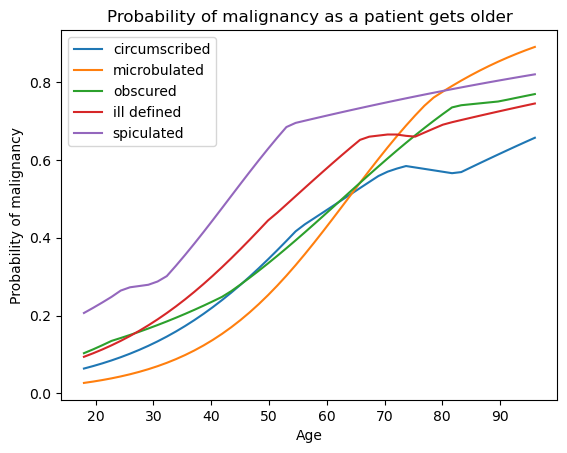

In [102]:
X_design = X.copy()
X_design_vec = pd.DataFrame(X_design.mean()).transpose()

for i in range(4, 9):
    X_design_vec.loc[0, ['margin2', 'margin3', 'margin4', 'margin5']] = [0, 0, 0, 0]
    if i != 4:
        X_design_vec.iloc[0, i] = 1
    
    min_resultant = min(X['age'])
    max_resultant = max(X['age'])
    seq = np.linspace(start= min_resultant, stop= max_resultant, num= 50)

    to_predict = []
    for result in seq:
        X_design_vec.loc[0, 'age'] = result
        to_predict.append(X_design_vec.copy())

    to_predict = pd.concat(to_predict)

    to_predict = scaler.transform(to_predict)
    preds = mlpc.predict_proba(to_predict)

    plt.plot(seq, preds[:, 1])
lgnd_labels = ['circumscribed', 'microbulated', 'obscured', 'ill defined','spiculated']
plt.xlabel('Age')
plt.ylabel('Probability of malignancy')
plt.title('Probability of malignancy as a patient gets older')
plt.legend(labels= lgnd_labels, loc = 'best')

### The purpose of the response curve is to provide a visual representation of the model's output. By displaying the changes in response due to changes in input we can visualise and understand the relationship between the variables of the network.
### Using this, we immediately observe an increased probability of malignancy as a person ages. There is a high inflection point between the ages 30 and 60 (50 for the spiculated margin). This indicates a rapid change in the probabilities of malignancy within this age group.
### The rapid increase is concerning and suggests that close attention should be given to members within this group as they are most likely to have malignancy. This should be a prompt to further conduct intensive research to better understand the factors that contribute to such rapid increases within this age group which in turn can improve the ability of the medical industry to detect malignancy earlier and provide efficient intervention measures.